## Import Autophagy Package

In [58]:
# Specific imports for cellular_raza
# The package is named cr_autophagy
# We want to reload the package when some of the behind-the scenes python functions change
# This is what the importlib statements are for
import importlib
import cr_autophagy as cra
importlib.reload(cra)

# Imports of general-purpose python libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyvista as pv
import multiprocessing as mp
from pathlib import Path
import os

output_path = cra.get_last_output_path()
# output_path = Path("out/autophagy/2023-11-24-18-05-41")
print(output_path)
simulation_settings = cra.get_simulation_settings(output_path)
iter_0_particles = cra.get_particles_at_iter(output_path, 0)
#for col in iter_0_particles.columns:
#    print(col)
max_iter = max(cra.get_all_iterations(output_path))

out\autophagy\2023-12-06-T09-53-55


In [60]:
# code to get cluster information
clusters = cra.get_cluster_information(output_path, max_iter,2.5)

# code to save cluster information plots
cra.save_cluster_information_plots(output_path, max_iter,2.5)

## Cluster Analysis

In [27]:
df = cra.get_particles_at_iter(output_path, max_iter)
 
cargo_at_end = df[df["element.cell.interaction.species"]=="Cargo"]["element.cell.mechanics.pos"]
cargo_at_end = np.array([np.array(elem) for elem in cargo_at_end])
non_cargo_at_end = df[df["element.cell.interaction.species"]!="Cargo"]["element.cell.mechanics.pos"]
non_cargo_at_end = np.array([np.array(elem) for elem in non_cargo_at_end])


In [28]:
import numpy as np
from scipy.spatial import distance

# Set max distance at which two cells are considered part of same cluster
connection_distance = 2.5


n_cells = simulation_settings.n_cells_r11
n_cargo = simulation_settings.n_cells_cargo

distance_matrix = [[0 for _ in range(n_cells)] for _ in range(n_cells)]
cargo_distance = np.zeros(n_cells)
connection_matrix = [[0 for _ in range(n_cells)] for _ in range(n_cells)]
cluster_size = np.zeros(n_cells).astype(int)
cluster_identity = np.zeros(n_cells).astype(int)


full_connection_matrix = [[0 for _ in range(n_cells)] for _ in range(n_cells)]

for i in range(n_cells):
    for j in range(n_cells):
        dist = distance.euclidean(non_cargo_at_end[i],non_cargo_at_end[j])
        distance_matrix[i][j] = dist
        distance_matrix[j][i] = dist
        connection_matrix[i][j] = dist < connection_distance
        connection_matrix[j][i] = dist < connection_distance
    for k in range(n_cargo):
        cargo_dist = distance.euclidean(non_cargo_at_end[i],cargo_at_end[k])
        if cargo_distance[i] > cargo_dist:
            cargo_distance[i] = cargo_dist
        elif cargo_distance[i] == 0:
            cargo_distance[i] = cargo_dist    

full_connection_matrix = connection_matrix

# Go through all cells again and connect each with all its connections connections
for i in range(n_cells):
    for p in range(n_cells):
        # For connected cells
        if connection_matrix[i][p] == 1:
            # Check their connections as well 
            for j in range(n_cells):
                # And if they are connected
                if connection_matrix[p][j] == 1:
                    # connect initial cell as well
                    full_connection_matrix[i][j] = 1
                    full_connection_matrix[j][i] = 1


cluster_identity_counter = 0
# Collect the cluster
for i in range(n_cells):
    cluster_size[i] = np.sum(full_connection_matrix[i],0)
    if cluster_identity[i] == 0:
        cluster_identity[i] = cluster_identity_counter
        cluster_identity_counter = cluster_identity_counter + 1
    for j in range(n_cells):
        if full_connection_matrix[i][j] == 1:
            if cluster_identity[j] == 0:
                cluster_identity[j] = cluster_identity_counter


cI = np.unique(cluster_identity, return_index=True)
min_cluster_cargo_distance = np.zeros(len(cI[1]))
clusters = [cluster_identity[cI[1]], cluster_size[cI[1]], min_cluster_cargo_distance]


# Check min distance of cluster to cargo
for k in range(np.max(cluster_identity)):
    for i in range(n_cells):
        if cluster_identity[i] == k+1:
            if min_cluster_cargo_distance[k] > cargo_distance[i]:
                min_cluster_cargo_distance[k] = cargo_distance[i]
            elif min_cluster_cargo_distance[k] == 0:
                min_cluster_cargo_distance[k] = cargo_distance[i]


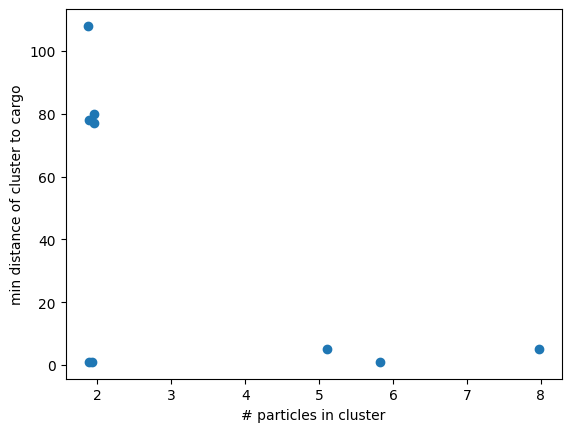

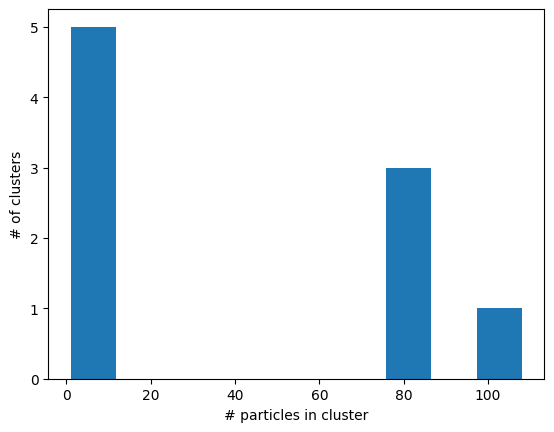

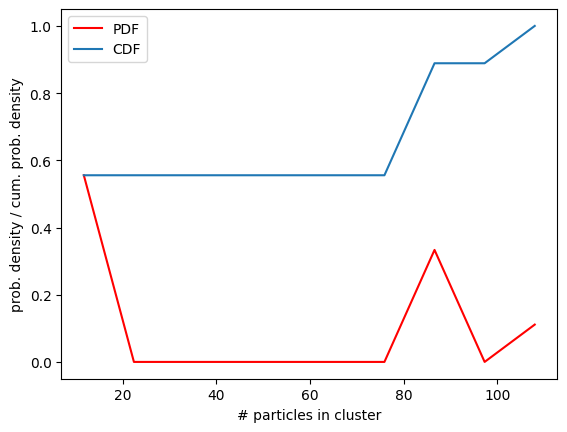

In [32]:
import matplotlib.pyplot as plt

# Clusters is triplet with (cluster_identity (links to individual particles), cluster size (amount of particles in cluster), minimum distance of cluster to cargo)
#clusters

#x = clusters[1]
#plt.hist(x)
#plt.show()

plt.scatter(clusters[2],clusters[1])
plt.xlabel('# particles in cluster')
plt.ylabel('min distance of cluster to cargo')
plt.show()


plt.hist(clusters[1])
plt.xlabel('# particles in cluster')
plt.ylabel('# of clusters')
plt.show()

# getting data of the histogram 
count, bins_count = np.histogram(clusters[1]) 
  
# finding the PDF of the histogram using count values 
pdf = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf = np.cumsum(pdf) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.xlabel('# particles in cluster')
plt.ylabel('prob. density / cum. prob. density')
plt.legend() 